# connect Google Drive, package install and import

## package install

In [ ]:
# mount your Google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.5 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import os,sys

import matplotlib        as mpl
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import interp1d
from scipy import stats
import seaborn as sns
import pandas as pd
import six
import time
import math
import pytz
import datetime
import importlib
import optuna
import joblib
from datetime import date
import locale
import pickle
locale.getpreferredencoding = lambda: "UTF-8"

# import modules for SSA
parDIR = '/content/drive/My Drive/ChromatinSpreadingModel/'
sys.path.append(parDIR)
import MUAmodel_minimal as MUAmodel

try:
    import cupy as xp
    import numpy as np
except ImportError:
    print('cupy was not imported. numpy instead')
    import numpy as xp
    import numpy as np

In [ ]:
# create output directory with today's date
today = date.today()
todaydate = today.strftime("%Y%m%d")
outDIR = './drive/My Drive/ChromatinSpreadingModel/output/'+todaydate+'/'
import os
if not(os.path.isdir(outDIR)):
  os.mkdir(outDIR)

In [ ]:
# mpl.rcParams['font.sans-serif'] = ""
# mpl.rcParams['font.family'] = ""
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['pdf.fonttype'] = 42 # make labels editable in pdf

## import expeirmental data

In [ ]:
# load contact freq

dname = parDIR+"experimentaldata/"
fname = "react_cfreq_interp.csv"
loop_react = xp.array(np.loadtxt(dname+fname,delimiter=",").astype('f'))
fname = "irr_cfreq_interp.csv"
loop_irr = xp.array(np.loadtxt(dname+fname,delimiter=",").astype('f'))

fname = "Knd_cfreq_interp.csv"
loop_Knd = xp.array(np.loadtxt(dname+fname,delimiter=",").astype('f'))
fname = "K1_cfreq_interp.csv"
loop_K1 = xp.array(np.loadtxt(dname+fname,delimiter=",").astype('f'))
fname = "K5_cfreq_interp.csv"
loop_K5 = xp.array(np.loadtxt(dname+fname,delimiter=",").astype('f'))

fname = "Kmut1_cfreq_interp.csv"
loop_Kmut1 = xp.array(np.loadtxt(dname+fname,delimiter=",").astype('f'))
fname = "Kmut5_cfreq_interp.csv"
loop_Kmut5 = xp.array(np.loadtxt(dname+fname,delimiter=",").astype('f'))

fname = "CNR_H3K9me3_interp.csv"
h3k9me3_timecourse = xp.array(np.loadtxt(dname+fname,delimiter=",").astype('f'))
mod_bg = h3k9me3_timecourse[:,0].reshape((h3k9me3_timecourse.shape[0],1))
h3k9me3_timecourse = h3k9me3_timecourse - xp.tile(mod_bg, (1, h3k9me3_timecourse.shape[1]))
# h3k9me3_exp = h3k9me3_exp - xp.tile(, (1, h3k9me3_exp.shape[1]))

fname = "CNR_H3K9me3_interp_Kmut1Kmut5K1K5.csv"
h3k9me3_exp = xp.array(np.loadtxt(dname+fname,delimiter=",").astype('f'))
h3k9me3_exp = h3k9me3_exp - xp.tile(mod_bg, (1, h3k9me3_exp.shape[1]))

dayList_K9me3timecourse = [-5, -4, 0, 2, 5, 10, 40, 40]

In [ ]:
# load KRAB memory dynamics
sil_fracs_KRAB = np.load(dname+'TFR001assoc_KRAB_OFFfrac.npy')

sil_fracs_avg_KRAB = np.nanmean(np.sqrt(sil_fracs_KRAB),axis=3)
sil_fracs_avg_KRAB = sil_fracs_avg_KRAB[0,1,:]
dayList_KRAB = [0, 2, 4, 6, 8, 10, 12, 16]

In [ ]:
# load KRAB memory dynamics
sil_fracs_MemSeries = np.load(dname+'KRABMemSeries_OFFfrac.npy')

sil_fracs_avg_MemSeries = np.nanmean(np.sqrt(sil_fracs_MemSeries),axis=3)
sil_fracs_avg_MemSeries = sil_fracs_avg_MemSeries[[2,3,0,1],1,:]
dayList_MemSeries = [0, 3, 4, 7, 8, 12, 16]

<ipython-input-9-54a4f2de6ef6>:4: RuntimeWarning: Mean of empty slice
  sil_fracs_avg_MemSeries = np.nanmean(np.sqrt(sil_fracs_MemSeries),axis=3)


In [ ]:
sqmem_exp = np.array([0.1083, 0.2694, 0.4339,0.6194]) # Kmut1, Kmut2, K1, K5

## reload module

In [ ]:
drive.mount('/content/drive',force_remount=True)
mtime = os.path.getmtime(parDIR+'MUAmodel_minimal.py')
print(datetime.datetime.fromtimestamp(mtime).strftime('%Y-%m-%d %H:%M:%S'))
importlib.reload(MUAmodel)

Mounted at /content/drive
2024-04-24 05:53:37


<module 'MUAmodel_minimal' from '/content/drive/My Drive/ChromatinSpreadingModel/MUAmodel_minimal.py'>

# Run MUA stochastic model

## define chromatin regulator recruitment/release dynamics
equilibration -> background silencing treand -> recruitment & silencing -> release & memory

In [ ]:
Tduration = 150
# Tduration = 400
# Tduration = 250
def RecruitmentAndRelease(x,NCELL,NNUC,init,loopmat):

    # --------------------------------------- #
    # DOX: determines if you take recruited CRs into account (1 if yes)
    # TSTEP: the interval to output the simulation results
    # LOOPNUM: number of loops with the interval defined by TSTEP (thus you simulate LOOPNUM*TSTEP hours)
    # --------------------------------------- #

    # ---- relaxation ---- #
    params =  x; DOX = 0;
    TSTEP = 2; LOOPNUM = int(24/TSTEP)*Tduration; # int(24/TSTEP)*150;
    out = MUAmodel.SSA(params,TSTEP,LOOPNUM,DOX,init,loopmat)
    return out

## old codes

Text(37.722222222222214, 0.5, 'average H3K9me3 level')

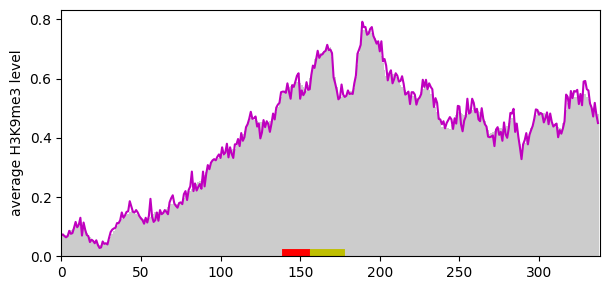

In [ ]:
f = plt.figure(figsize=(6,3))
idx = 3
h3k9me3_d5 = h3k9me3_exp[int(h3k9me3_exp.shape[0]/2)-NNUC/2:int(h3k9me3_exp.shape[0]/2)+NNUC/2,idx]
# h3k9me3_d5 = h3k9me3_timecourse[int(h3k9me3_exp.shape[0]/2)-NNUC/2:int(h3k9me3_exp.shape[0]/2)+NNUC/2,2]
plt.bar(range(0,h3k9me3_d5.shape[0]),xp.asnumpy(h3k9me3_d5), color=[0.8,0.8,0.8], width=1)
plt.plot(range(0,h3k9me3_d5.shape[0]),xp.asnumpy(xp.mean(out['MUA'][idx][:,:,0],axis=0).flatten()),'m-')
plt.plot((MUAmodel.pEF_s,MUAmodel.Cit_e),(0,0),'y-',linewidth=10)
plt.plot((MUAmodel.ppp1r12c_s,MUAmodel.ppp1r12c_e),(0,0),'r-',linewidth=10)
plt.xlim((0,len(h3k9me3_d5)))
plt.tight_layout()
plt.ylabel('average H3K9me3 level',fontsize=10)
# f.savefig(outDIR+'/avgH3K9me3_init.pdf',transparent=True)

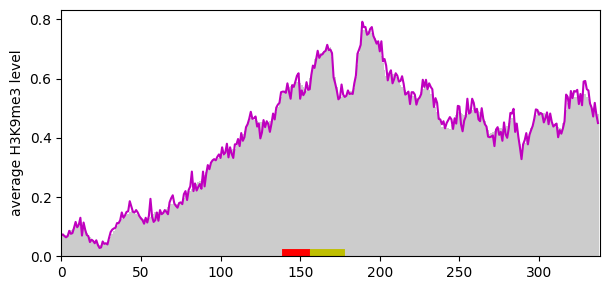

In [ ]:
f = plt.figure(figsize=(6,3))
h3k9me3_d5 = h3k9me3_exp[int(h3k9me3_exp.shape[0]/2)-NNUC/2:int(h3k9me3_exp.shape[0]/2)+NNUC/2,3]
# h3k9me3_d5 = h3k9me3_timecourse[int(h3k9me3_exp.shape[0]/2)-NNUC/2:int(h3k9me3_exp.shape[0]/2)+NNUC/2,2]
plt.bar(range(0,h3k9me3_d5.shape[0]),xp.asnumpy(h3k9me3_d5), color=[0.8,0.8,0.8], width=1)
plt.plot(range(0,h3k9me3_d5.shape[0]),xp.asnumpy(xp.mean(init,axis=0).flatten()),'m-')
plt.plot((MUAmodel.pEF_s,MUAmodel.Cit_e),(0,0),'y-',linewidth=10)
plt.plot((MUAmodel.ppp1r12c_s,MUAmodel.ppp1r12c_e),(0,0),'r-',linewidth=10)
plt.xlim((0,len(h3k9me3_d5)))
plt.tight_layout()
plt.ylabel('average H3K9me3 level',fontsize=10)
# f.savefig(outDIR+'/avgH3K9me3_init.pdf',transparent=True)

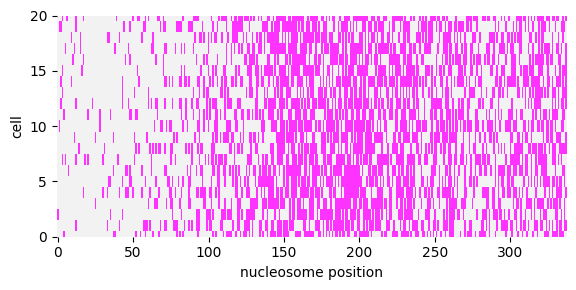

In [ ]:
dat = xp.asnumpy(init)
cmap = np.vstack(([0.2 ,0.7 ,0.6],[0.95 ,0.95 ,0.95],[1.0 ,0.2 ,1.0]))
cmap = mpl.colors.ListedColormap(cmap,cmap.shape[0])
f = plt.figure(figsize=(6,3))
plt.imshow(dat,aspect='auto',interpolation='none',vmax=1.0,vmin=-1.0,cmap=cmap)
plt.plot((MUAmodel.pEF_s,MUAmodel.Cit_e),(-1,-1),'y-',linewidth=10)
plt.plot((MUAmodel.ppp1r12c_s,MUAmodel.ppp1r12c_e),(-1,-1),'r-',linewidth=10)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.ylabel('cell',fontsize=10)
plt.xlabel('nucleosome position',fontsize=10)
plt.ylim((0,20))
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.tight_layout()
f.savefig(outDIR+'/avgH3K9me3_representative.pdf',transparent=True)

In [ ]:
# 0.046 = -math.log(0.5)/15
# 0.035 = -math.log(0.5)/20

0.03465735902799726

In [ ]:
# set parameters, run MUA model
# ---- parameters ---- #
kfAA = 0.0001; kfAM = 0.005; kfMM = 0.00048; kfMA = 0.05 # feedback reaction rate
kdA_nonrep = 0.1; kdM_nonrep = 0.046; kbA_nonrep = 0.0; kbM_nonrep = 0.0;  # background modification rate at non-reporter region
kbA_rep = 0.08; kbA_ppp1r12c = 0.08 # background modification rate at the reporters

In [ ]:
# set parameters, run MUA model
# ---- parameters ---- #
kfAA = 0.0001; kfAM = 0.005; kfMM = 0.00048; kfMA = 0.05 # feedback reaction rate
kdA_nonrep = 0.1; kdM_nonrep = 0.046; kbA_nonrep = 0.0; kbM_nonrep = 0.0;  # background modification rate at non-reporter region
kbA_rep = 0.15; kbA_ppp1r12c = 0.15 # background modification rate at the reporters

# ---- parameters 2  ---- #
NCELL = 500 # will be divided into 2 conditions: no spacer, 1.2kb, 3kb or 5kb spacer
NNUC = loop_irr.shape[0] # number of nucleosomes
MUAmodel.DefineElementCoordinate(NNUC)
MUAmodel.DefineStateSpecificLoop(loop_irr, loop_react)
kcat = 0.0; K0H1 = 0.0; # KRAB K0H1: 0 if KRAB recruited, 1 if HDAC4 recruited
k_feedback = xp.float32([kfAA, kfAM, kfMM, kfMA])
k_background = xp.float32([kdA_nonrep,kdM_nonrep,kbA_nonrep,kbM_nonrep,kbA_rep,kbA_ppp1r12c])
k_recruit = xp.float32([kcat, K0H1])
params  = (k_feedback, k_background, k_recruit)
params0 = (xp.float32([0.0, 0.0, 0.0, 0.0]), k_background, k_recruit)

# ---- initial condition ---- #
# init = -1.0 *xp.ones((NCELL,NNUC)).astype('f') # all the nucleosome are acetylated in the initial condition
# init = xp.ones((NCELL,NNUC)).astype('f')
# init[:,MUAmodel.pEF_s] = -1.0
h3k9me3_d5 = h3k9me3_exp[int(h3k9me3_exp.shape[0]/2)-NNUC/2:int(h3k9me3_exp.shape[0]/2)+NNUC/2,2]
init = 0.0 * xp.ones((NCELL,NNUC)).astype('f')
for ii in range(0,NNUC):
    init[xp.random.random(NCELL) < h3k9me3_d5[ii],ii] = 1.0

# ---- run simulation ---- #
start = time.time()
out_K5, UIRdynamics_K5 = RecruitmentAndRelease(params,NCELL,NNUC,init,loop_K5)
out_Knd, UIRdynamics_Knd = RecruitmentAndRelease(params,NCELL,NNUC,init,loop_Knd)
elapsed_time = time.time() - start
print ("elapsed time:{0}".format(elapsed_time) + "[sec]")

KeyboardInterrupt: 

In [ ]:
print([xp.mean(UIRdynamics_K5[:,0,-1]),xp.mean(UIRdynamics_K5[:,1,-1]),xp.mean(UIRdynamics_K5[:,2,-1])])
print([xp.mean(UIRdynamics_Knd[:,0,-1]),xp.mean(UIRdynamics_Knd[:,1,-1]),xp.mean(UIRdynamics_Knd[:,2,-1])])


[array(0., dtype=float32), array(0.622, dtype=float32), array(0.378, dtype=float32)]
[array(0., dtype=float32), array(0.448, dtype=float32), array(0.552, dtype=float32)]


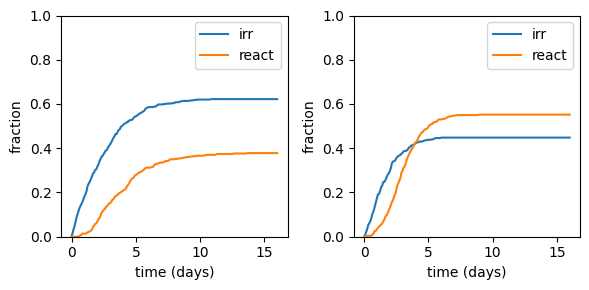

In [ ]:
plt.figure(figsize=(6,3))

for ii in range(0,2):
    plt.subplot(1,2,ii+1)
    match ii:
        case 0:
            dat = UIRdynamics_K5
        case 1:
            dat = UIRdynamics_Knd

    avgtimecourse = xp.asnumpy(xp.mean(dat[:,1,:],axis=0))
    Tduration = 16
    xax = np.linspace(0,Tduration,len(avgtimecourse))

    plt.plot(xax,avgtimecourse)
    avgtimecourse = xp.asnumpy(xp.mean(dat[:,2,:],axis=0))
    plt.plot(xax,xp.asnumpy(xp.mean(dat[:,2,:],axis=0)))
    plt.legend(['irr','react'])
    plt.ylim(0,1)
    plt.xlabel('time (days)')
    plt.ylabel('fraction')
    plt.tight_layout()


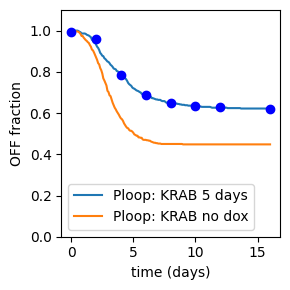

In [ ]:
plt.figure(figsize=(3,3))

for ii in range(0,2):
    # plt.subplot(1,2,ii+1)
    match ii:
        case 0:
            dat = UIRdynamics_K5
        case 1:
            dat = UIRdynamics_Knd

    avgtimecourse = 1 - xp.asnumpy(xp.mean(dat[:,2,:],axis=0))
    Tduration = 16
    xax = np.linspace(0,Tduration,len(avgtimecourse))
    plt.plot(xax,avgtimecourse)
plt.plot(dayList_KRAB, sil_fracs_avg_KRAB, color='b', marker='o', linestyle='')
plt.legend(['Ploop: KRAB 5 days','Ploop: KRAB no dox'])
plt.ylim(0,1.1)
plt.xlabel('time (days)')
plt.ylabel('OFF fraction')
plt.tight_layout()


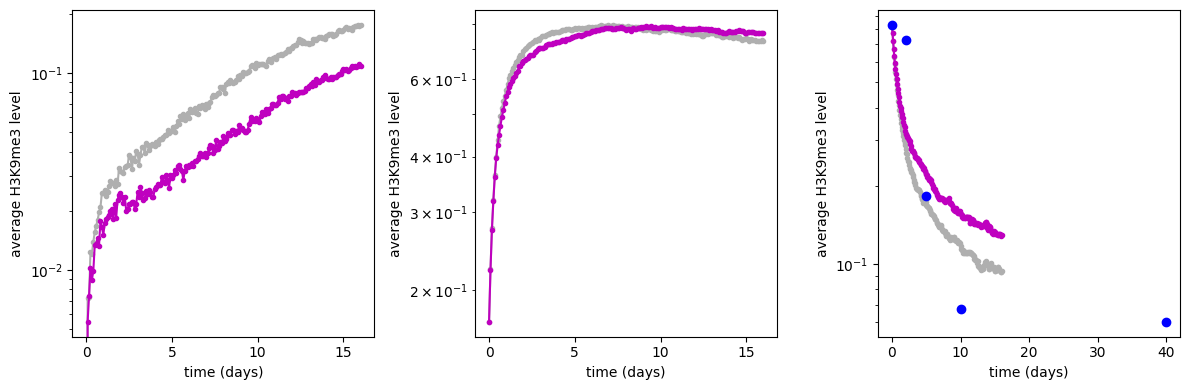

In [ ]:
# f = plt.figure(figsize=(16,4))
h3k9me3_exp_rangematched = h3k9me3_exp[int(h3k9me3_exp.shape[0]/2)-NNUC/2:int(h3k9me3_exp.shape[0]/2)+NNUC/2,:]
quantrange = range(MUAmodel.puro_s,MUAmodel.Cit_e+1)
# quantrange = range(0,out_K5.shape[1])
cmap = ['#afafaf','m']
Tduration = 16
f = plt.figure(figsize=(12,4))
for i in range(0,3): # range(0,3):
    plt.subplot(1,3,i+1)
    for jj in range(0,2): # (0,2): #
        match jj:
            case 0:
                dat = out_Knd # out_nofb
            case 1:
                dat = out_K5
        avgtimecourse = xp.asnumpy(np.mean(np.mean(dat[:,quantrange,:] == i-1,axis=1),axis=0).flatten())
        avgtimecourse = avgtimecourse # /avgtimecourse[0]
        xax = np.linspace(0,Tduration,len(avgtimecourse))
        plt.plot(xax,avgtimecourse,linestyle="-",marker=".",color=cmap[jj])
    plt.yscale('log')
    if i == 2:
        plt.plot([0,2,5,10,40],xp.asnumpy(xp.mean(h3k9me3_exp_rangematched[quantrange,2:-1],axis=0)),'bo')
        plt.plot([40],xp.asnumpy(xp.mean(h3k9me3_exp_rangematched[quantrange,-1],axis=0)),'ro')
    # plt.ylim([0,0.52])
    # plt.ylim([0.005,1.2])
    # plt.xlim([-5.0,150.0])
    # plt.xlim([-1.0,10.0])
    plt.xlabel('time (days)',fontsize=10)
    plt.ylabel('average H3K9me3 level',fontsize=10)
    plt.tight_layout()


In [ ]:
quantrange = range(0,dat.shape[1])
dat[[0,1,10],quantrange,:]

ValueError: operands could not be broadcast together with shapes(3,) (338,)

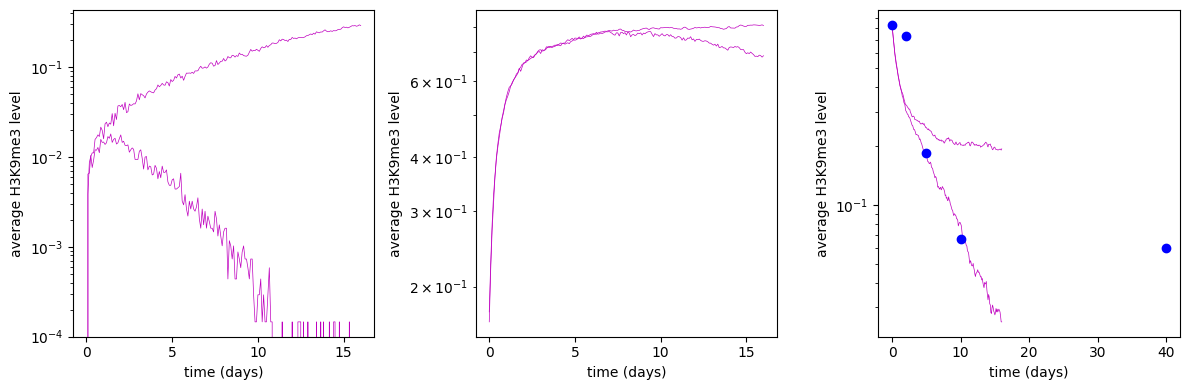

In [ ]:
# f = plt.figure(figsize=(16,4))
h3k9me3_exp_rangematched = h3k9me3_exp[int(h3k9me3_exp.shape[0]/2)-NNUC/2:int(h3k9me3_exp.shape[0]/2)+NNUC/2,:]
quantrange = range(MUAmodel.puro_s,MUAmodel.Cit_e+1)
# quantrange = range(0,out_K5.shape[1])
quantrange = np.array(list(quantrange))
cmap = ['#afafaf','m']
Tduration = 16
f = plt.figure(figsize=(12,4))
for i in range(0,3): # range(0,3):
    plt.subplot(1,3,i+1)
    for jj in range(1,2): # (0,2): #
        match jj:
            case 0:
                dat = out_Knd # out_nofb
                uir = UIRdynamics_Knd
            case 1:
                dat = out_K5
                uir = UIRdynamics_K5
        # avgtimecourse = xp.asnumpy(np.mean(np.mean(dat[uir[:,1,-1] == 1,quantrange,:] == i-1,axis=1),axis=0).flatten())
        xax = np.linspace(0,Tduration,len(avgtimecourse))
        avgtimecourse = xp.asnumpy(np.mean(np.mean(dat[xp.ix_(uir[:,2,-1] == 0,quantrange)] == i-1,axis=1),axis=0).flatten())
        plt.plot(xax,avgtimecourse,linestyle="-",marker="",color=cmap[jj], linewidth=0.5)
        avgtimecourse = xp.asnumpy(np.mean(np.mean(dat[xp.ix_(uir[:,2,-1] == 1,quantrange)] == i-1,axis=1),axis=0).flatten())
        plt.plot(xax,avgtimecourse,linestyle="-",marker="",color=cmap[jj], linewidth=0.5)
    plt.yscale('log')
    if i == 2:
        plt.plot([0,2,5,10,40],xp.asnumpy(xp.mean(h3k9me3_exp_rangematched[quantrange,2:-1],axis=0)),'bo')
        plt.plot([40],xp.asnumpy(xp.mean(h3k9me3_exp_rangematched[quantrange,-1],axis=0)),'ro')
    plt.xlabel('time (days)',fontsize=10)
    plt.ylabel('average H3K9me3 level',fontsize=10)
    plt.tight_layout()


In [ ]:
# if it changes a0 to a1 within time x0,
# a1 = a2*2^(-x0/tau) -> tau = -x0 / (log2(a1/a2))
a1 = xp.asnumpy(xp.mean(h3k9me3_exp_rangematched[quantrange,2:-1],axis=0))[-1]
a2 = xp.asnumpy(xp.mean(h3k9me3_exp_rangematched[quantrange,2:-1],axis=0))[-2]
x0 = 30
tau = -x0 / (np.log2(a1/a2))
print(tau)

36.519959866364395


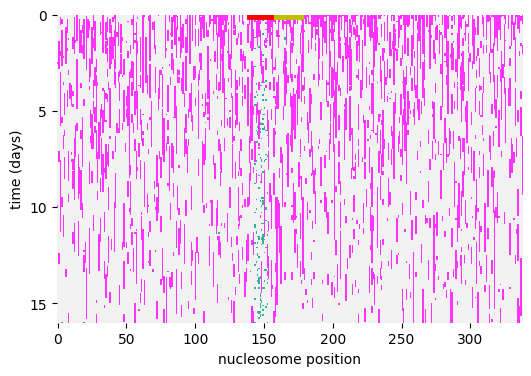

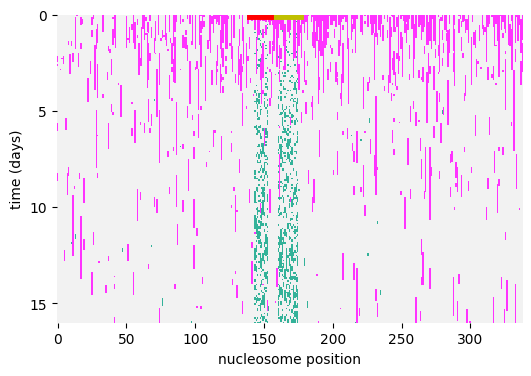

In [ ]:
## visualization
cmap = np.vstack(([0.2 ,0.7 ,0.6],[0.95 ,0.95 ,0.95],[1.0 ,0.2 ,1.0]))
cmap = mpl.colors.ListedColormap(cmap,cmap.shape[0])
idx = [5] # 3
cond_names = ['krab 5', 'krab nd']
# dat = xp.asnumpy(out_nofb)

for ii in range(0,len(cond_names)):
    match ii:
        case 0:
            dat = xp.asnumpy(out_K5) # xp.asnumpy(out_nofb)
        case 1:
            dat = xp.asnumpy(out_Knd)
    hrs_per_frame = 12
    start_date_offset = 0
    yax_idx = np.linspace(0,dat.shape[2]-1,int((dat.shape[2]-1)/hrs_per_frame)+1)
    yax_day = np.linspace(0+start_date_offset,(dat.shape[2]-1)/hrs_per_frame+start_date_offset,int((dat.shape[2]-1)/hrs_per_frame)+1).astype('int')
    f = plt.figure(figsize=(6,4))
    for i in range(0,len(idx)):
        plt.subplot(1,len(idx),i+1)
        plt.imshow(dat[idx[i],:,:].reshape((dat.shape[1],dat.shape[2])).T,aspect='auto',interpolation='none',vmax=1.0,vmin=-1.0,cmap=cmap)
        plt.plot((MUAmodel.pEF_s,MUAmodel.Cit_e),(-1,-1),'y-',linewidth=10)
        plt.plot((MUAmodel.ppp1r12c_s,MUAmodel.ppp1r12c_e),(-1,-1),'r-',linewidth=10)
        for pos in ['right', 'top', 'bottom', 'left']:
            plt.gca().spines[pos].set_visible(False)
        plt.ylabel('time (days)',fontsize=10)
        plt.xlabel('nucleosome position',fontsize=10)
        # plt.title('cell #'+str(idx[i]),fontsize=20)
        # plt.yticks(ticks = [0,4,12,24,34],labels = [-1,0,2,5,15],fontsize=20)
        # plt.yticks(ticks = [0,48,96,144,192,240,288],labels = [-1,0,1,2,3,4,5],fontsize=20)
        plt.yticks(ticks = yax_idx[0::5],labels = yax_day[0::5],fontsize=10)
        plt.yticks(fontsize=10)
        plt.xticks(fontsize=10)
        new_var = yax_idx[-1]
        plt.ylim((new_var,0))
        # plt.xlim((125,250))
    plt.show()
    # f.savefig(outDIR+'/heatmap_'+cond_names[ii]+'.pdf',transparent=True)

In [ ]:
cond_names = ['nofb', 'react', 'irr']

for ii in range(0,len(cond_names)):
    match ii:
        case 0:
            out = out_nofb
        case 1:
            out = out_react
        case 2:
            out = out_irr
    with open(outDIR+'simulatedmatrix_'+cond_names[ii]+'.npy', 'wb') as f:
        xp.save(f, out, allow_pickle=False)

In [ ]:
with open(outDIR+'simulatedmatrix_init.npy', 'wb') as f:
    xp.save(f, init, allow_pickle=False)

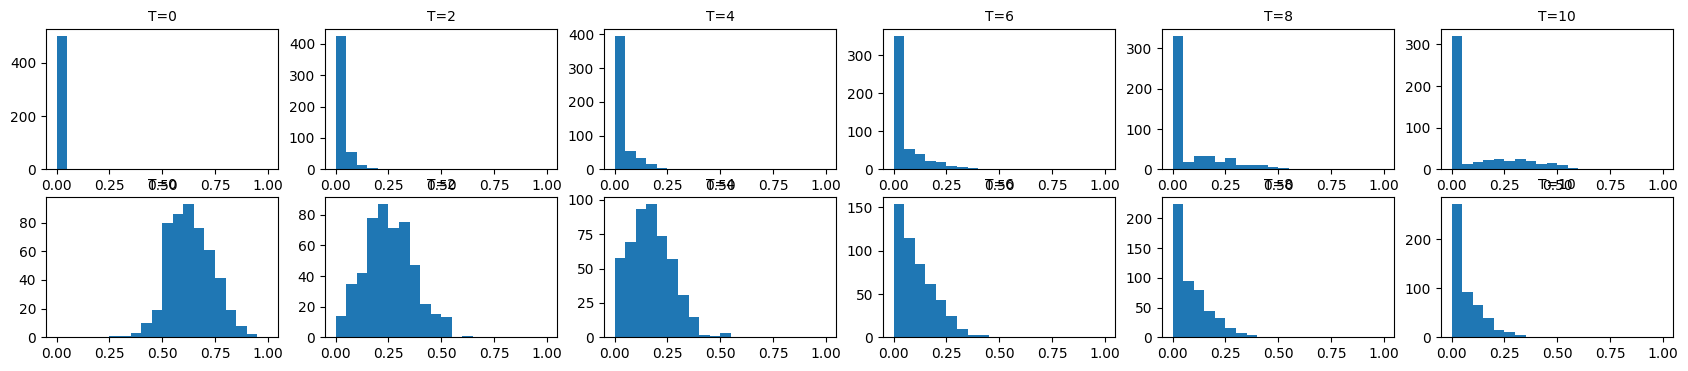

In [ ]:
dat = xp.asnumpy(out['MUA'][3])

f = plt.figure(figsize=(21,4))
# jjrange = range(0,int((dat.shape[2]-1)/12)+1)
# jjrange = range(0,50,10)
jjrange = range(0,11,2)
for i in range(0,2):
    for id, jj in enumerate(jjrange):
        plt.subplot(len(range(0,2)),len(jjrange),int(id+1)+i*len(jjrange))
        # plt.hist(np.mean(dat[:,:,jj*12] == -1+i*2,axis=1),bins=20,range=(0,1))
        plt.hist(np.mean(dat[:,MUAmodel.puro_s:(MUAmodel.Cit_e+1),jj*12] == -1+i*2,axis=1),bins=20,range=(0,1))
        # plt.ylabel('time',fontsize=20)
        # plt.xlabel('nucleosome position',fontsize=20)
        plt.title('T='+str(jj),fontsize=10)
        plt.yticks(fontsize=10)
        plt.xticks(fontsize=10)
        # plt.ylim((0,100))
plt.show()

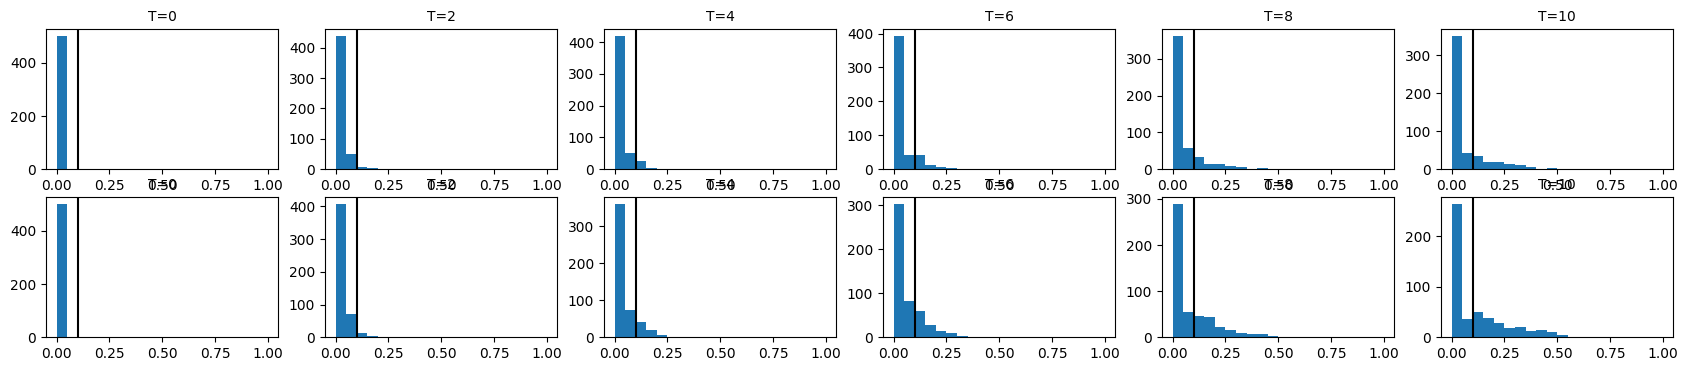

In [ ]:
f = plt.figure(figsize=(21,4))
jjrange = range(0,11,2)
# jjrange = range(0,50,10)
for i in range(0,2):
    match i:
        case 0:
            dat = xp.asnumpy(out_K5)
            und = xp.asnumpy(UIRdynamics_K5[:,0,:])
        case 1:
            dat = xp.asnumpy(out_Knd)
            und = xp.asnumpy(UIRdynamics_Knd[:,0,:])

    for id, jj in enumerate(jjrange):
        plt.subplot(len(range(0,2)),len(jjrange),int(id+1)+i*len(jjrange))
        # datavg = np.mean(dat[und[:,jj*12] == 1,MUAmodel.puro_s:(MUAmodel.Cit_e+1),jj*12] == -1,axis=1)
        datavg = np.mean(dat[:,MUAmodel.puro_s:(MUAmodel.Cit_e+1),jj*12] == -1,axis=1)
        plt.hist(datavg,bins=20,range=(0,1))
        plt.axvline(x=0.10,color='k')
        plt.title('T='+str(jj),fontsize=10)
        plt.yticks(fontsize=10)
        plt.xticks(fontsize=10)
        # plt.ylim((0,100))
plt.show()

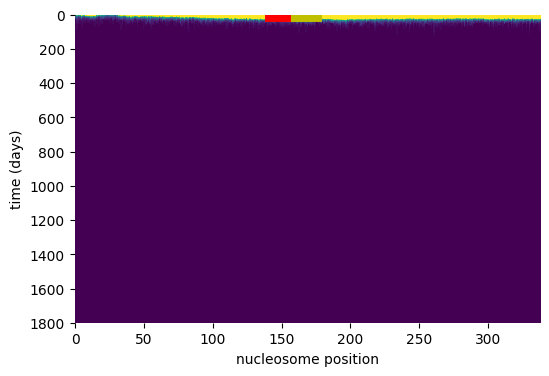

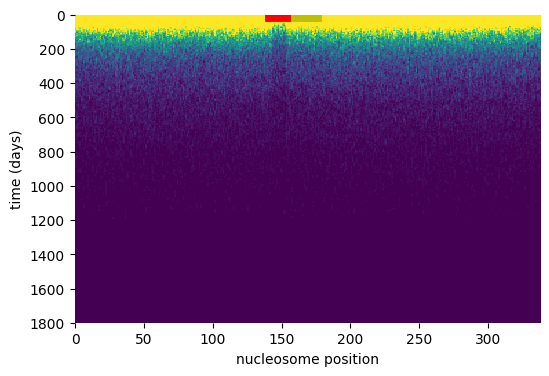

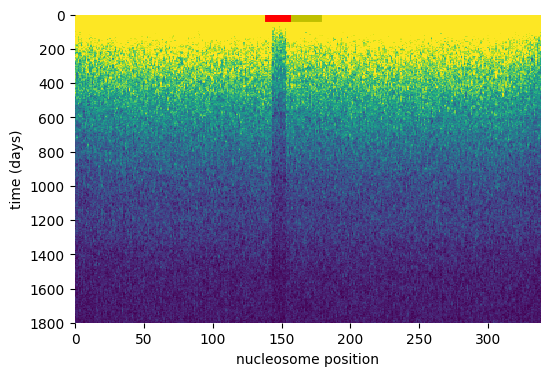

In [ ]:
## visualization
cmap = np.vstack(([0.2 ,0.7 ,0.6],[0.95 ,0.95 ,0.95],[1.0 ,0.2 ,1.0]))
cmap = mpl.colors.ListedColormap(cmap,cmap.shape[0])
# idxshift = 2
idx = [3] # [0+idxshift,round(NCELL/2+idxshift)]
# idx = [7,1009]
cond_names = ['nofb', 'react', 'irr']
# dat = xp.asnumpy(out_nofb)

for ii in range(0,len(cond_names)):
    match ii:
        case 0:
            dat = xp.asnumpy(out_nofb)
        case 1:
            dat = xp.asnumpy(out_react)
        case 2:
            dat = xp.asnumpy(out_irr)
    hrs_per_frame = 12
    start_date_offset = 0
    yax_idx = np.linspace(0,dat.shape[2]-1,int((dat.shape[2]-1)/hrs_per_frame)+1)
    yax_hr = np.linspace(0+start_date_offset,(dat.shape[2]-1)/hrs_per_frame+start_date_offset,int((dat.shape[2]-1)/hrs_per_frame)+1)
    f = plt.figure(figsize=(6,4))
    for i in range(0,len(idx)):
        plt.subplot(1,len(idx),i+1)
        plt.imshow(np.mean(dat == 1,axis=0).T,aspect='auto',interpolation='none',vmax=0.1,vmin=0.0)
        plt.plot((MUAmodel.pEF_s,MUAmodel.Cit_e),(-1,-1),'y-',linewidth=10)
        plt.plot((MUAmodel.ppp1r12c_s,MUAmodel.ppp1r12c_e),(-1,-1),'r-',linewidth=10)
        for pos in ['right', 'top', 'bottom', 'left']:
            plt.gca().spines[pos].set_visible(False)
        plt.ylabel('time (days)',fontsize=10)
        plt.xlabel('nucleosome position',fontsize=10)
        # plt.title('cell #'+str(idx[i]),fontsize=20)
        # plt.yticks(ticks = [0,4,12,24,34],labels = [-1,0,2,5,15],fontsize=20)
        # plt.yticks(ticks = [0,48,96,144,192,240,288],labels = [-1,0,1,2,3,4,5],fontsize=20)
        # plt.yticks(ticks = yax_idx,labels = yax_hr,fontsize=20)
        plt.yticks(fontsize=10)
        plt.xticks(fontsize=10)
        new_var = 12*150
        plt.ylim((new_var,0))
        # plt.xlim((125,250))
    plt.show()
    # f.savefig(outDIR+'/heatmap_avg_'+cond_names[ii]+'.pdf',transparent=True)


(0.0, 1.0)

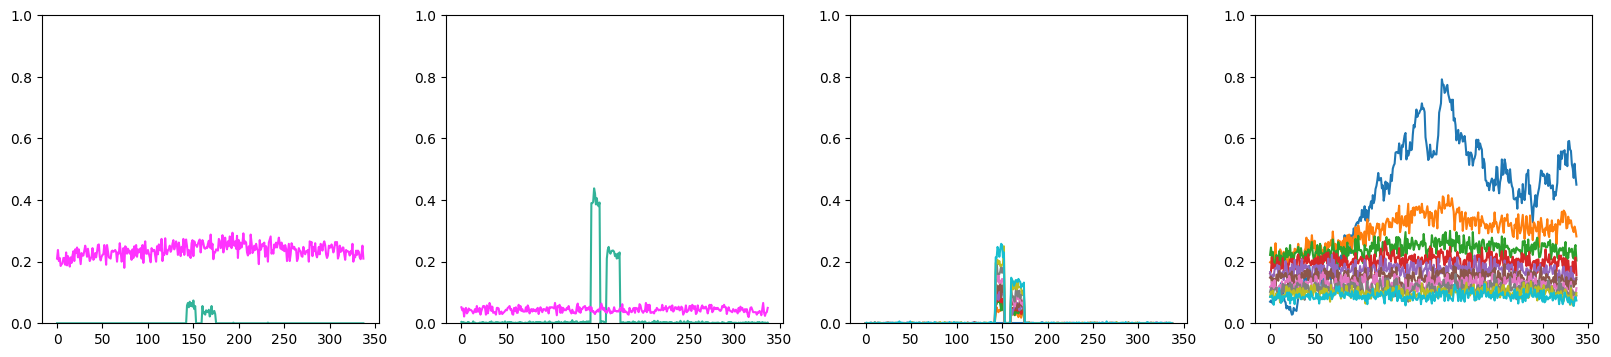

In [ ]:
dat = xp.asnumpy(out['MUA'][3])
cmap = np.vstack(([0.2 ,0.7 ,0.6],[0.95 ,0.95 ,0.95],[1.0 ,0.2 ,1.0]))
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.plot(np.mean(dat[:,:,24+1] == -1,axis=0),color=cmap[0,:])
plt.plot(np.mean(dat[:,:,24+1] == 1,axis=0),color=cmap[2,:])
plt.ylim(0,1)

plt.subplot(1,4,2)
plt.plot(np.mean(dat[:,:,12*10*2] == -1,axis=0),color=cmap[0,:])
plt.plot(np.mean(dat[:,:,12*10*2] == 1,axis=0),color=cmap[2,:])
plt.ylim(0,1)

plt.subplot(1,4,3)
for i in range(0,120,12):
    plt.plot(np.mean(dat[:,:,i] == -1,axis=0))
plt.ylim(0,1)

plt.subplot(1,4,4)
for i in range(0,120,12):
    plt.plot(np.mean(dat[:,:,i] == 1,axis=0))
plt.ylim(0,1)

(0.0, 1.0)

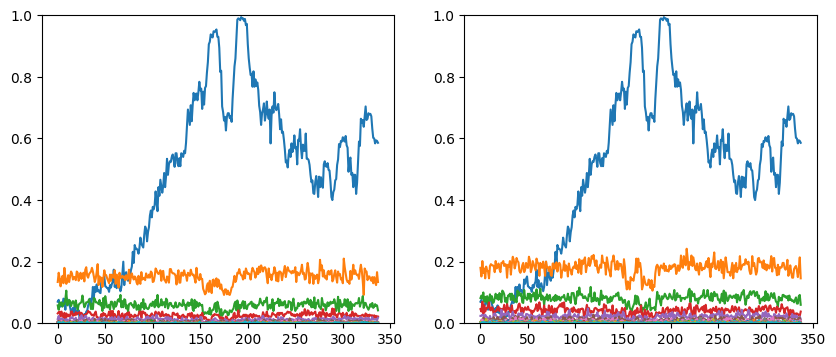

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
dat = xp.asnumpy(out_react)
for i in range(0,600,6*5):
    plt.plot(np.mean(dat[:,:,i] == 1,axis=0))
plt.ylim(0,1)

plt.subplot(1,2,2)
dat = xp.asnumpy(out_irr)
for i in range(0,600,6*5):
    plt.plot(np.mean(dat[:,:,i] == 1,axis=0))
plt.ylim(0,1)

In [ ]:
bg_sig = xp.asnumpy(xp.mean(h3k9me3_exp_rangematched[quantrange,2:-1],axis=0))[-1]

[0.2984790943171494, 2.3222637489761366]
[0.2389222370212341, 2.901141347083328]


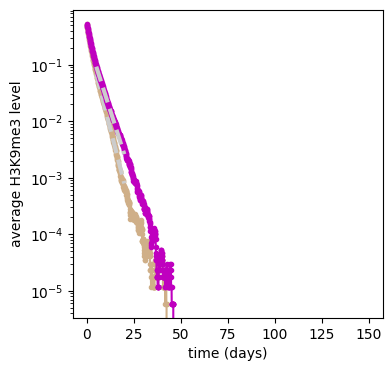

In [ ]:
cmap = ['#cfaf88','m']

def linearfunc(x, a, b):
    return a*x + b
def expfunc(x, a, b):
    return b*np.exp(-a*x)
# x_st = 10; x_ed = 75
x_st = 5; x_ed = 20
fig = plt.figure(figsize=(4,4))
for ii in range(0,2):
    match ii:
        case 0:
            dat = out_react
        case 1:
            dat = out_irr
    avgtimecourse = xp.asnumpy(np.mean(np.mean(dat[:,quantrange,:] == 1,axis=1),axis=0).flatten())
    xax = np.linspace(0,Tduration,len(avgtimecourse))
    st = np.where(xax == x_st)[0][0]
    ed = np.where(xax == x_ed)[0][0]
    xdata = xax[st:ed]
    ydata = avgtimecourse[st:ed]
    popt, pcov, infordict, mesg, ier = sp.optimize.curve_fit(expfunc, xdata, ydata, p0 = [0.001,1], full_output=True)
    print([popt[0],-np.log(0.5)/popt[0]])
    plt.plot(xax,avgtimecourse,'.-', color=cmap[ii])
    plt.plot(xdata,expfunc(xdata,*popt),'--', color=[0.8,0.8,0.8], linewidth=3)
    plt.ylabel('average H3K9me3 level')
    plt.xlabel('time (days)')
plt.yscale('log')


(0.0, 0.52)

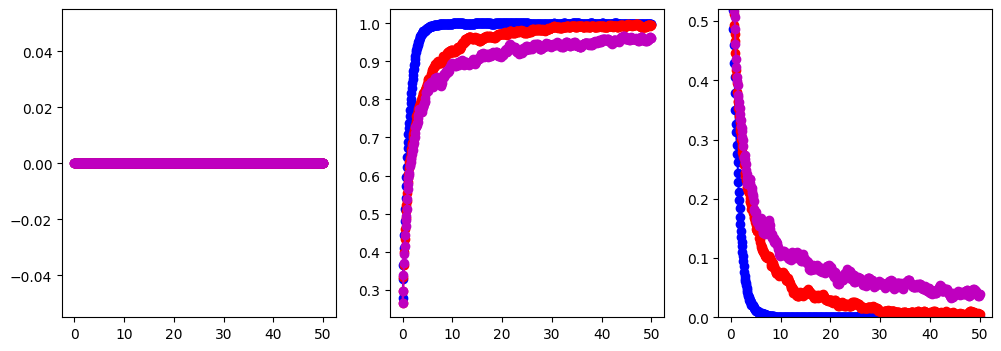

In [ ]:
f = plt.figure(figsize=(12,4))
Tduration = 50
for i in range(0,3):
    plt.subplot(1,3,i+1)
    avgtimecourse = xp.asnumpy(np.mean(np.mean(out_nofb[:,MUAmodel.pEF_s:MUAmodel.Cit_e,:] == i-1,axis=1),axis=0).flatten())
    xax = np.linspace(0,Tduration,len(avgtimecourse))
    plt.plot(xax,avgtimecourse,linestyle="-",marker="o",color='b')

    avgtimecourse = xp.asnumpy(np.mean(np.mean(out_react[:,MUAmodel.pEF_s:MUAmodel.Cit_e,:] == i-1,axis=1),axis=0).flatten())
    xax = np.linspace(0,Tduration,len(avgtimecourse))
    plt.plot(xax,avgtimecourse,linestyle="-",marker="o",color='r')

    avgtimecourse = xp.asnumpy(np.mean(np.mean(out_irr[:,MUAmodel.pEF_s:MUAmodel.Cit_e,:] == i-1,axis=1),axis=0).flatten())
    xax = np.linspace(0,Tduration,len(avgtimecourse))
    plt.plot(xax,avgtimecourse,linestyle="-",marker="o",color='m')
    # plt.yscale('log')
plt.ylim([0,0.52])
# plt.xlim([0,15])


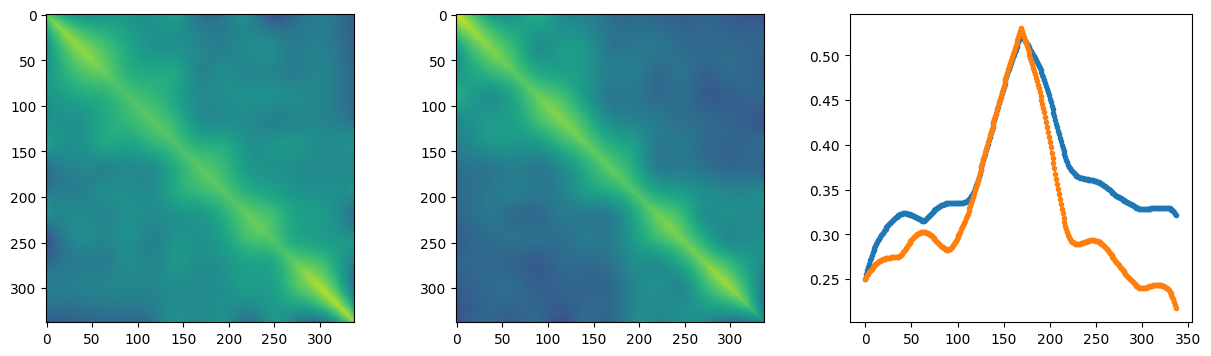

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(xp.asnumpy(loop_irr).T,aspect='equal',interpolation='none',vmax=0.7,vmin=0.0)
plt.subplot(1,3,2)
plt.imshow(xp.asnumpy(loop_react).T,aspect='equal',interpolation='none',vmax=0.7,vmin=0.0)
plt.subplot(1,3,3)
plt.plot(xp.asnumpy(loop_irr[int(loop_irr.shape[0]/2),:]),'.-')
plt.plot(xp.asnumpy(loop_react[int(loop_react.shape[0]/2),:]),'.-')

In [ ]:
## save

timenow = datetime.datetime.now()
timenow = timenow.astimezone(pytz.timezone('US/Pacific'))
timenow = timenow.strftime('%Y-%m-%d-%H-%M-%S')
f1name = DIR+'/out_'+timenow+'_matrix.csv'
f2name = DIR+'/out_'+timenow+'_params.csv'

start = time.time()

# save matrix
f=open(f1name,'a')
for i in range(0,out.shape[2]):
    np.savetxt(f, xp.asnumpy(out[:,:,i]), delimiter=',')
f.close()
# save parameters
f=open(f2name,'a')
for i in range(0,len(params)):
    np.savetxt(f, xp.asnumpy(params[i]), delimiter=',')
f.close()

elapsed_time = time.time() - start
print ("elapsed time:{0}".format(elapsed_time) + "[sec]")

elapsed time:23.079231023788452[sec]


# Different memory series simulation

In [ ]:
NCELL = 500 # number of cells
NNUC = loop_irr.shape[0] # number of nucleosomes
MUAmodel.DefineElementCoordinate(NNUC)

In [ ]:
# set parameters, run MUA model
# ---- parameters ---- #
# feedback reaction rate kfMM = 0.00041 for MUA-UIR model
kfAA = 0.0; kfAM = 0.0; kfMM = 0.00037; kfMA = 0.0 # matches experimental results
# kfAA = 0.0; kfAM = 0.0; kfMM = 0.0006; kfMA = 0.0 # strong feedback
kfAA = 0.0; kfAM = 0.0; kfMM = 0.00042; kfMA = 0.0 # strong feedback
kdA_nonrep = 0.0; kdM_nonrep = 0.046; kbA_nonrep = 0.0; kbM_nonrep = 0.0;  # background modification rate at non-reporter region
kbA_rep = 0.0; kbA_ppp1r12c = 0.0 # background modification rate at the reporters

# ---- parameters 2  ---- #
NCELL = 500 # number of cells
NNUC = loop_irr.shape[0] # number of nucleosomes
MUAmodel.DefineElementCoordinate(NNUC)
kcat = 0.0; K0H1 = 0.0; # KRAB K0H1: 0 if KRAB recruited, 1 if HDAC4 recruited
k_feedback = xp.float32([kfAA, kfAM, kfMM, kfMA])
k_background = xp.float32([kdA_nonrep,kdM_nonrep,kbA_nonrep,kbM_nonrep,kbA_rep,kbA_ppp1r12c])
k_recruit = xp.float32([kcat, K0H1])
params  = (k_feedback, k_background, k_recruit)
params0 = (xp.float32([0.0, 0.0, 0.0, 0.0]), k_background, k_recruit)

# --- empty dictionary for data storage --- #
out = {'MUA':[], 'Name':['K5','Knd','nofb']}
outCD = {'MUA':[], 'Name':['K5','Knd','nofb']}
outNofb = {'MUA':[], 'Name':['K5','Knd','nofb']}
start = time.time()
# ---- initial condition ---- #
h3k9me3_prob = h3k9me3_timecourse[int(h3k9me3_timecourse.shape[0]/2)-NNUC/2:int(h3k9me3_timecourse.shape[0]/2)+NNUC/2,2]
init = 0.0 * xp.ones((NCELL,NNUC)).astype('f')
for ii in range(0,NNUC):
    init[xp.random.random(NCELL) < h3k9me3_prob[ii],ii] = 1.0
for kk in range(0,3):
    # ---- run simulation ---- #
    match kk:
        case 0:
            MUA  = RecruitmentAndRelease(params,NCELL,NNUC,init,loop_K5)
            out['MUA'].append(MUA)
        case 1:
            MUA = RecruitmentAndRelease(params,NCELL,NNUC,init,loop_Knd)
            out['MUA'].append(MUA)
        case 2:
            MUA = RecruitmentAndRelease(params0,NCELL,NNUC,init,loop_K5)
            out['MUA'].append(MUA)

elapsed_time = time.time() - start
print ("elapsed time:{0}".format(elapsed_time) + "[sec]")

elapsed time:297.7131690979004[sec]


In [ ]:
MUAmodel.Cit_e-MUAmodel.pEF_s+1

15

In [ ]:
sil_fracs_avg_MemSeries[:,-1]

array([0.11129064, 0.27312829, 0.4447938 , 0.62161747])

In [ ]:
hits = []
idx = -1
uiridx = 1 # 2 for react, 1 for irr
while idx < out['UIR'][3].shape[0]-1:
    idx += 1
    if out['UIR'][3][idx,uiridx,-1] == 1:
        tmp = xp.where(out['UIR'][3][idx,uiridx,:] == 1)[0][0]/12
        if tmp == 4:
            print(idx)
            hits.append(idx)


197


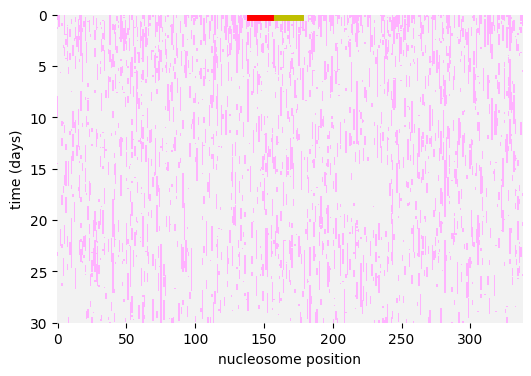

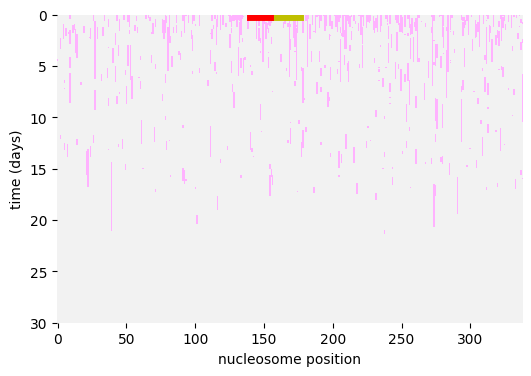

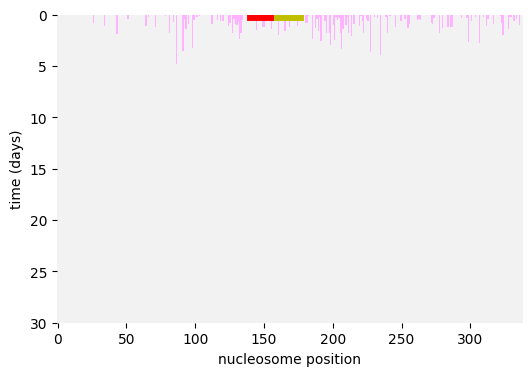

In [ ]:
## visualization, each condition
# cmap = np.vstack(([0.2 ,0.7 ,0.6],[0.95 ,0.95 ,0.95],[1.0 ,0.2 ,1.0]))
cmap = np.vstack(([0.2 ,0.7 ,0.6],[0.95 ,0.95 ,0.95],[1.0 ,0.7 ,1.0]))
cmap = mpl.colors.ListedColormap(cmap,cmap.shape[0])
# idx = [0]
idx = [15,2,2]
# dat = xp.asnumpy(out_nofb)

for ii in range(0,3): # range(0,len(cond_names)):
    cond_names = out['Name'][ii]
    dat = xp.asnumpy(out['MUA'][ii][:,:,0:((12*30)+1)]) #
    hrs_per_frame = 12
    start_date_offset = 0
    yax_idx = np.linspace(0,dat.shape[2]-1,int((dat.shape[2]-1)/hrs_per_frame)+1)
    yax_day = np.linspace(0+start_date_offset,(dat.shape[2]-1)/hrs_per_frame+start_date_offset,int((dat.shape[2]-1)/hrs_per_frame)+1).astype('int')
    # f = plt.figure(figsize=(6,4))
    f = plt.figure(figsize=(6,4))
    # plt.subplot(1,len(idx),i+1)
    plt.imshow(dat[idx[ii],:,:].reshape((dat.shape[1],dat.shape[2])).T,aspect='auto',interpolation='none',vmax=1.0,vmin=-1.0,cmap=cmap)
    plt.plot((MUAmodel.pEF_s,MUAmodel.Cit_e),(-1,-1),'y-',linewidth=10)
    plt.plot((MUAmodel.ppp1r12c_s,MUAmodel.ppp1r12c_e),(-1,-1),'r-',linewidth=10)
    for pos in ['right', 'top', 'bottom', 'left']:
        plt.gca().spines[pos].set_visible(False)
    plt.ylabel('time (days)',fontsize=10)
    plt.xlabel('nucleosome position',fontsize=10)
    plt.yticks(ticks = yax_idx[0::5],labels = yax_day[0::5],fontsize=10)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    new_var = yax_idx[-1]
    plt.ylim((new_var,0))
    # plt.xlim((125,250))
    plt.show()
    # f.savefig(outDIR+'/heatmap_highfb_'+cond_names+'_idx_'+str(idx[i])+'.pdf',transparent=True)
    # f.savefig(outDIR+'/heatmap_matchedfb_'+cond_names+'_idx_'+str(idx[i])+'.pdf',transparent=True)

In [ ]:
out['MUA'][1].shape

(500, 338, 1801)

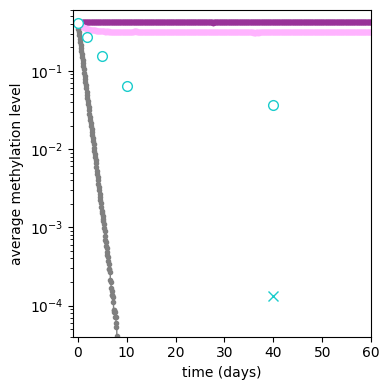

In [ ]:
# plot average A or M for irr / react at the end point
NNUC = loop_irr.shape[1]
h3k9me3_exp_rangematched = h3k9me3_timecourse[int(h3k9me3_exp.shape[0]/2)-NNUC/2:int(h3k9me3_exp.shape[0]/2)+NNUC/2,:]
ylab = ['average acetylation level', 'average methylation level']
cmap = np.vstack(([0.6 ,0.2 ,0.6],[1.0 ,0.7 ,1.0],[0.5,0.5,0.5]))

f = plt.figure(figsize=(4,4))
for jj in range(0,3): # (0,2): #
    dat = xp.asnumpy(out['MUA'][jj])
    avgtimecourse = np.mean(np.mean(dat == 1,axis=1),axis=0).flatten()
    xax = np.linspace(0,Tduration,len(avgtimecourse))
    plt.step(xax,avgtimecourse,linestyle="-",marker=".",color=cmap[jj], linewidth=1, where='post')
tmp = np.mean(xp.asnumpy(h3k9me3_exp_rangematched),axis=0)
plt.plot(dayList_K9me3timecourse[2:-1] , tmp[2:-1], markeredgecolor=[0.1,0.8,0.8], marker='o', linestyle='', color='w', markersize=7)
plt.plot(dayList_K9me3timecourse[-1:] , tmp[-1:], markeredgecolor=[0.1,0.8,0.8], marker='x', linestyle='', color='w', markersize=7)
plt.yscale('log')
plt.ylim(4*10**-5,0.6)
# plt.ylim(-0.02,0.6)
plt.xlim(-1,60)
plt.xlabel('time (days)',fontsize=10)
plt.ylabel(ylab[1],fontsize=10)
plt.tight_layout()
# f.savefig(outDIR+'/MetDyn_toohighfb.pdf',transparent=True)
# f.savefig(outDIR+'/MetDyn_matchedfb_closeup.pdf',transparent=True)
# f.savefig(outDIR+'/MetDyn_toohighfb_closeup.pdf',transparent=True)

In [ ]:
outDIR

'./drive/My Drive/ChromatinSpreadingModel/output/20240515/'

In [ ]:
# save
with open(outDIR+'out_matched_fb.pkl', 'wb') as f:
    pickle.dump(out, f)

In [ ]:
# save
with open(outDIR+'out_toohigh_fb.pkl', 'wb') as f:
    pickle.dump(out, f)

In [ ]:
# load
outDIR2 = outDIR +'/../20240529_minimalmodel_RecapExperimentNicely/'
with open(outDIR2+'out_toohigh_fb.pkl', 'rb') as f:
    out = pickle.load(f)


## Bayesian optimization

### initial screening

In [ ]:
h3k9me3_exp_rangematched = h3k9me3_exp[int(h3k9me3_exp.shape[0]/2)-NNUC/2:int(h3k9me3_exp.shape[0]/2)+NNUC/2,:]
dat_exp = xp.mean(h3k9me3_exp_rangematched[:,2:-1],axis=0)
dat_exp.shape

(5,)

In [ ]:
def fmin_func(params,NCELL,NNUC,init,loop_irr):
    # ---- generate 3d random walk polymers ---- #
    out_irr = RecruitmentAndRelease(params,NCELL,NNUC,init,loop_irr)
    h3k9me3_exp_rangematched = h3k9me3_exp[int(h3k9me3_exp.shape[0]/2)-NNUC/2:int(h3k9me3_exp.shape[0]/2)+NNUC/2,:]
    dat_exp = xp.mean(h3k9me3_exp_rangematched[:,2:-1],axis=0)
    # ---- calculate error ---- #
    error = xp.sum((xp.mean(xp.mean(out_irr[:,:,[0*12,2*12,5*12,10*12,40*12]],axis=1),axis=0) - dat_exp)**2)
    return error


In [ ]:
kfAA = 0.00025; kfAM = 0.003; kfMM = 0.00035; kfMA = 0.004 # feedback reaction rate
kdA_nonrep = 0.1; kdM_nonrep = 0.035; kbA_nonrep = 0.0; kbM_nonrep = 0.0;  # background modification rate at non-reporter region
kbA_rep = 0.0 # background modification rate at the reporters
kbA_ppp1r12c = 0.1 # background modification rate at PPP1R12C promoter

In [ ]:
# ## find parameters for a given distance matrix using optuna 20240411
# NCELL = 100
# cmin = 0.0001
# cmax = 0.01

# def objective(trial):
#     k_feedback = xp.float32((trial.suggest_float('p0', 0.0001, 0.01),
#                                 trial.suggest_float('p1', cmin, cmax),
#                                 trial.suggest_float('p2', 0.0001, 0.01),
#                                 trial.suggest_float('p3', cmin, cmax)))

#     k_background = xp.float32((0.1,0.035,0.0,0.0,0.0,
#                                trial.suggest_float('p4', 0.001, 0.1)))

#     params = (k_feedback, k_background, k_recruit)
#     score = fmin_func(params,NCELL,NNUC,init,loop_irr)
#     return score

# Nfit = 1
# dname = outDIR
# start = time.time()
# for ii in range(0,Nfit):
#     # Create a study object and optimize the objective function.
#     study = optuna.create_study(sampler=optuna.samplers.TPESampler(prior_weight=1000.0))
#     study.optimize(objective, n_trials=300)
#     joblib.dump(study, dname+"study_N"+str(ii)+".pkl")

# elapsed_time = time.time() - start
# print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")


[I 2024-04-11 23:26:02,727] A new study created in memory with name: no-name-9c5c8d63-1d61-40f4-8553-84cf6bd76705
[I 2024-04-11 23:27:17,880] Trial 0 finished with value: 2.475348711013794 and parameters: {'p0': 0.008509777967423362, 'p1': 0.0010233846252258256, 'p2': 0.002529426887630731, 'p3': 0.00744942321530198, 'p4': 0.048668421056525336}. Best is trial 0 with value: 2.475348711013794.
[I 2024-04-11 23:30:17,004] Trial 1 finished with value: 3.6760449409484863 and parameters: {'p0': 0.0056870448975672675, 'p1': 0.0028323078409096423, 'p2': 0.0005922154157696986, 'p3': 0.00037890521768413154, 'p4': 0.08770496712104292}. Best is trial 0 with value: 2.475348711013794.
[I 2024-04-11 23:31:42,462] Trial 2 finished with value: 3.006880760192871 and parameters: {'p0': 0.005154303911455535, 'p1': 0.004263941622219625, 'p2': 0.009224315408578463, 'p3': 0.002586037699454723, 'p4': 0.03461697395825042}. Best is trial 0 with value: 2.475348711013794.
[I 2024-04-11 23:33:05,063] Trial 3 finish

elapsed_time:27190.47566151619[sec]


# test codes

## limited enzyme implementation

In [ ]:
nucleosome = xp.random.choice([0, 1], size=(500, 300), p=[0.84, 0.16])

NCELL, NNUC = nucleosome.shape

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(nucleosome),aspect='auto',interpolation='none',vmax=1.0,vmin=0)
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(new_matrix),aspect='auto',interpolation='none',vmax=1.0,vmin=0)
plt.show()
plt.figure
plt.hist(xp.asnumpy(xp.sum(nucleosome == 1, axis=1)))
plt.hist(xp.asnumpy(xp.sum(new_matrix == 1, axis=1)))
plt.show()

In [ ]:
# idea 1

start = time.time()

new_matrix = xp.zeros_like(nucleosome)

for i in range(NCELL):
    # Find indices where the value is 1
    indices = xp.where(nucleosome[i] == 1)[0]

    if len(indices) >= 60:

        # If there are 50 or more elements with value 1, randomly select 50 of them
        selected_indices = xp.random.choice(indices, 60, replace=False)

        # Set these indices to 1 in the new matrix
        new_matrix[i, selected_indices] = 1
    else:
        # If there are fewer than 50 elements with value 1, copy the row as is
        new_matrix[i] = nucleosome[i]

elapsed_time = time.time() - start
print ("elapsed time:{0}".format(elapsed_time) + "[sec]")

elapsed time:0.09958553314208984[sec]


In [ ]:
# idea 2

start = time.time()

new_matrix = xp.zeros_like(nucleosome)

# Count the number of ones in each row
ones_count = xp.sum(nucleosome == 1, axis=1)
# Identify rows with fewer than 50 ones and copy them directly
less_than_50_mask = ones_count < 60
new_matrix[less_than_50_mask] = nucleosome[less_than_50_mask]

# For rows with at least 50 ones, we still need some form of iteration
# due to the need to randomly select indices
rows_with_at_least_50_ones = xp.where(ones_count >= 60)[0]

for row in rows_with_at_least_50_ones:
    ones_indices = xp.where(nucleosome[row] == 1)[0]
    selected_indices = xp.random.choice(ones_indices, 60, replace=False)
    new_matrix[row, selected_indices] = 1

elapsed_time = time.time() - start
print ("elapsed time:{0}".format(elapsed_time) + "[sec]")

## fastest for there are not so many rows > threshold

elapsed time:0.021279573440551758[sec]


In [ ]:
xp.minimum(1,50/ones_count).reshape((500,1)) * (nucleosome == 1).astype('f')

array([[0.        , 0.        , 0.        , ..., 0.        , 0.98039216,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# idea 3

start = time.time()

sequence_mask = xp.zeros_like(nucleosome, dtype=int)

for i in range(NCELL):
    # Find indices where the nucleosome has 1s
    ones_indices = xp.where(nucleosome[i] == 1)[0]
    # Shuffle these indices to randomize their order
    xp.random.shuffle(ones_indices)
    # Assign increasing sequence numbers to the shuffled indices
    # This ensures that the selection of 1s is randomized
    sequence_mask[i, ones_indices] = xp.arange(1, len(ones_indices) + 1)

# Now, create a mask to select up to 50 1s in each row
# For rows with fewer than 50 1s, all will be selected
selection_mask = (sequence_mask > 0) & (sequence_mask <= 60)

# Apply the selection mask, setting unselected 1s to 0
new_matrix = nucleosome * selection_mask

elapsed_time = time.time() - start
print ("elapsed time:{0}".format(elapsed_time) + "[sec]")

## fastest when there are many rows > threshold, slowest when there are many rows < threshold

elapsed time:0.24680423736572266[sec]


In [ ]:
start = time.time()

sequence_mask = xp.zeros((NCELL,NNUC))
# test = xp.concatenate((sequence_mask,sequence_mask),axis=1)

test = xp.zeros((NCELL,NNUC*2))
test[:,0:NNUC] = sequence_mask
test[:,NNUC:(NNUC*2)] = sequence_mask



elapsed_time = time.time() - start
print ("elapsed time:{0}".format(elapsed_time) + "[sec]")



elapsed time:0.0013804435729980469[sec]


In [ ]:
start = time.time()

# test_prv = xp.zeros((NCELL,NNUC*2))
# test_prv[:,1:(NNUC*2)] = test[:,0:(NNUC*2-1)]
# hits = xp.sign(test - test_prv).astype('f')

hits = xp.sign(xp.diff(test,axis=1)).astype('f')

elapsed_time = time.time() - start
print ("elapsed time:{0}".format(elapsed_time) + "[sec]")
d

elapsed time:0.0008006095886230469[sec]


## test JIT compiler

In [ ]:
from numba import jit, prange, cuda

In [ ]:
@jit(nopython=True, parallel=True)
def my_function(data):
    result = np.empty_like(data)
    for i in prange(data.shape[0]):
        result[i] = data[i] ** 2
    return result

start = time.time()

data = np.arange(1000)
squared_data = my_function(data)

elapsed_time = time.time() - start
print ("elapsed time:{0}".format(elapsed_time) + "[sec]")



elapsed time:0.28818511962890625[sec]


In [ ]:
start = time.time()

data = np.arange(1000)
squared_data = data ** 2

elapsed_time = time.time() - start
print ("elapsed time:{0}".format(elapsed_time) + "[sec]")

elapsed time:0.0002875328063964844[sec]


In [ ]:
# idea 2 without JIT

start = time.time()
Mtot =10
MwithRW = xp.zeros_like(nucleosome, dtype='f')
M = (nucleosome == 1).astype('f')

mark_count = xp.sum(M, axis=1)
less_than_thresh_mask = mark_count <= Mtot
MwithRW[less_than_thresh_mask] = M[less_than_thresh_mask]
rows_with_more_than_thresh = xp.where(mark_count > Mtot)[0]
for row in rows_with_more_than_thresh:
    ones_indices = xp.where(M[row])[0]
    selected_indices = xp.random.choice(ones_indices, Mtot, replace=False)
    MwithRW[row, selected_indices] = 1

elapsed_time = time.time() - start
print ("elapsed time:{0}".format(elapsed_time) + "[sec]")

## fastest for there are not so many rows > threshold

elapsed time:0.3272585868835449[sec]


In [ ]:
@jit(nopython=True, parallel=True)
def limitedenzyme(M,Mtot,rows_with_more_than_thresh):
    MwithRW = np.zeros_like(M, dtype='f')
    for row in rows_with_more_than_thresh:
        # ones_indices = np.where(M[row])[0]
        # selected_indices = np.random.choice(ones_indices, Mtot, replace=False)
        selected_indices = np.where(M[row])[0]
        MwithRW[row, selected_indices] = 1
    return MwithRW


In [ ]:
# idea 2 without JIT

start = time.time()
Mtot =10
M = (nucleosome == 1).astype('f')
MwithRW = xp.zeros_like(nucleosome, dtype='f')

mark_count = xp.sum(M, axis=1)
less_than_thresh_mask = mark_count <= Mtot
MwithRW[less_than_thresh_mask] = M[less_than_thresh_mask]
rows_with_more_than_thresh = xp.where(mark_count > Mtot)[0]
M = xp.asnumpy(M)
rows_with_more_than_thresh = xp.asnumpy(rows_with_more_than_thresh)
MwithRW = limitedenzyme(M,Mtot,rows_with_more_than_thresh)

elapsed_time = time.time() - start
print ("elapsed time:{0}".format(elapsed_time) + "[sec]")

## fastest for there are not so many rows > threshold

elapsed time:0.1791543960571289[sec]


/usr/local/lib/python3.10/dist-packages/numba/core/typed_passes.py:334: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "<ipython-input-278-12a3537f6c6c>", line 2:
@jit(nopython=True, parallel=True)
def limitedenzyme(M,Mtot,rows_with_more_than_thresh):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


In [ ]:
@cuda.jit
def add_kernel(x, y, out):
    tx = cuda.threadIdx.x  # Thread id in a 1D block
    ty = cuda.blockIdx.x   # Block id in a 1D grid
    bw = cuda.blockDim.x   # Block width, i.e., number of threads per block
    pos = tx + ty * bw

    if pos < x.size:  # Check array bounds
        out[pos] = x[pos] + y[pos]

# Use the CuPy array in a Numba kernel
threads_per_block = 32
blocks_per_grid = (M.size + (threads_per_block - 1)) // threads_per_block
add_kernel[blocks_per_grid, threads_per_block](x_cp, y_cp, out_cp)


In [ ]:
xp.min

# test code: separated reaction rate comparison

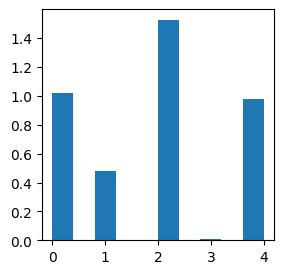

In [ ]:
count = np.zeros((5,1))
count = []
# Example reaction rates and separate r2
rrates = np.array([1.0, 0.5, 1.5, 0.01])
r2 = 1.0 # 0.2

# Include r2 in the array for normalization
rates_with_r2 = np.append(rrates, r2)

# Normalize the rates
total = np.sum(rates_with_r2)
normalized_rates = rates_with_r2 / total

for i in range(3000):
    # Generate a random number
    rand_num = np.random.rand()

    # Find the cumulative sum and select the rate
    cumulative_sum = np.cumsum(normalized_rates)
    index = np.where(cumulative_sum >= rand_num)[0][0]

    # Resulting selected rate
    selected_rate = rates_with_r2[index]
    # count[index] += 1
    count.append(index)

weights = np.ones_like(count) / len(count) * (np.sum(rrates)+r2)
plt.figure(figsize=(3,3))
plt.hist(count, weights=weights)
plt.show()

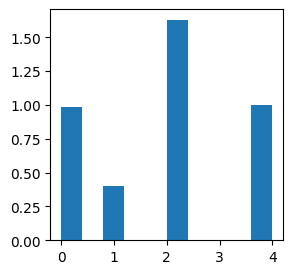

In [ ]:
count = []
# Example reaction rates and separate r2
rrates = np.array([1.0, 0.5, 1.5, 0.01])
r2 = 1.0 # 0.2

# Normalize the rrates array only
total_rrates = np.sum(rrates)
normalized_rrates = rrates / (total_rrates+r2)

for i in range(3000):
    # Find the cumulative sum and select the rate from rrates
    rand_num = np.random.rand()
    cumulative_sum = np.cumsum(normalized_rrates)
    index = np.where(cumulative_sum >= rand_num)[0][0]
    selected_from_rrates = rrates[index]

    # Now decide between selected_from_rrates and r2
    # We use the original values to reflect their actual reaction rate contribution
    total_selection = selected_from_rrates + r2 /(total_rrates)
    probability_pick_rrate = selected_from_rrates / total_selection

    # Generate another random number for the final selection
    rand_num_final = np.random.rand()

    # Compare and pick the final rate
    if rand_num_final < probability_pick_rrate:
        final_pick = index
        source = 'rrates'
    else:
        final_pick = 4
        source = 'r2'

    count.append(final_pick)

weights = np.ones_like(count) / len(count) * (np.sum(rrates)+r2)
plt.figure(figsize=(3,3))
plt.hist(count, weights=weights)
plt.show()

In [ ]:
cumulative_sum /(cumulative_sum+r2)

array([0.62421973, 0.71360609, 0.83287063, 0.83333333])